<a href="https://colab.research.google.com/github/YunusovYF/neural_networks/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_ultra_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra pro

Возьмите базу трафика с сайта компании. Напишите модель для прогнозирования трафика. 

Возьмите xLen = 60. Добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

In [ ]:
# Загружаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Baza/traff.csv', sep=',')

In [ ]:
data.head()

,Date,Price
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"


In [ ]:
data = data.drop('Date', 1)

In [ ]:
print(data.head())

       Price
0  22,226.00
1  29,593.00
2  31,726.00
3  32,684.00
4  31,820.00


In [ ]:
meanPrice = []

In [ ]:
for index, row in data.iterrows():
  row['Price']=float(row['Price'].replace(',',''))
  mPrice = 0
  for i in range(-4,6):
    try:
      mPrice += data.iloc[index+i]['Price']
    except:
      mPrice += row['Price']

  meanPrice.append(mPrice/10)

In [ ]:
data['meanPrice'] = meanPrice

In [ ]:
data = np.array(data)

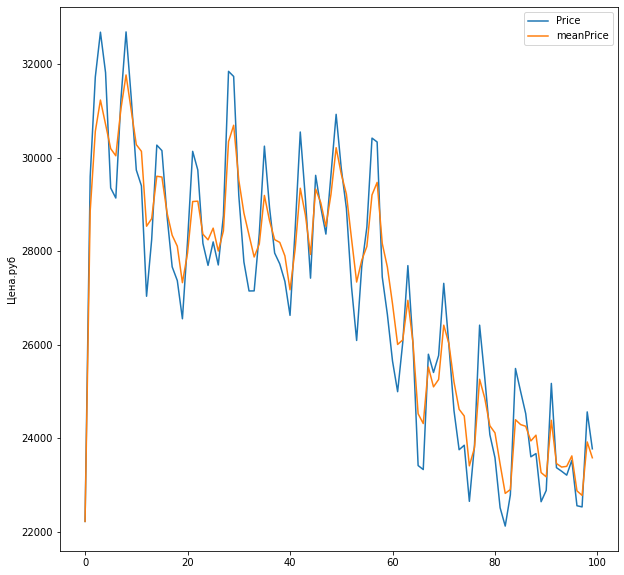

In [ ]:
# Отрисовываем график данных
plt.figure(figsize=(10,10))
start = 0
stop = 100
chanelNames = ['Price', 'meanPrice']
for i in range(2):
  plt.plot(data[start:start+stop,i],
           label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

In [ ]:
# Формируем параметры загрузки данных
xLen = 60
valLen = 1000
trainLen = data.shape[0]-valLen

# Делим данные на траин и тест
xTrain, xTest = data[:trainLen], data[trainLen + xLen + 2:]

# Масштабируем данные
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain, yTest = np.reshape(data[:trainLen,0],(-1,1)), np.reshape(data[trainLen+xLen+2:,0],(-1,1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

# Создаём генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,
                                   length=xLen, stride=1, sampling_rate=1,
                                   batch_size=20)

# Создаём генератор для валидации обучения
testDataGen = TimeseriesGenerator(xTest, yTest,
                                  length=xLen, stride=1,
                                  batch_size=20)

In [ ]:
yTrain[0]

array([0.00946611])

In [ ]:
xTrain[0]

array([0.00946611, 0.        ])

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 60, 2) (20, 1)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
2/2 [==============================] - 9s 1s/step - loss: 0.0552 - val_loss: 0.0891
Epoch 2/40
2/2 [==============================] - 0s 264ms/step - loss: 0.0163 - val_loss: 0.0659
Epoch 3/40
2/2 [==============================] - 0s 273ms/step - loss: 0.0425 - val_loss: 0.0678
Epoch 4/40
2/2 [==============================] - 0s 262ms/step - loss: 0.0255 - val_loss: 0.0812
Epoch 5/40
2/2 [==============================] - 0s 260ms/step - loss: 0.0114 - val_loss: 0.0993
Epoch 6/40
2/2 [==============================] - 0s 272ms/step - loss: 0.0180 - val_loss: 0.1088
Epoch 7/40
2/2 [==============================] - 0s 266ms/step - loss: 0.0255 - val_loss: 0.1041
Epoch 8/40
2/2 [==============================] - 0s 254ms/step - loss: 0.0184 - val_loss: 0.0917
Epoch 9/40
2/2 [==============================] - 0s 263ms/step - loss: 0.0118 - val_loss: 0.0800
Epoch 10/40
2/2 [==============================] - 0s 260ms/step - loss: 0.0106 - val_loss: 0.0738
Epoch 11/40
2/2 [=====

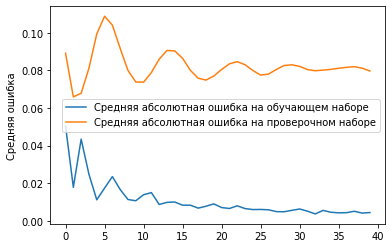

In [ ]:
# Полносвязная сеть
dataInput = Input(shape=(xLen,2))

lstmWay = LSTM(40, return_sequences="True")(dataInput)
lstmWay = Dropout(0.3)(lstmWay)

convWay = Conv1D(100, 5, activation="relu")(dataInput)

lstmWay = LSTM(40, return_sequences="True")(lstmWay)
lstmWay = Dropout(0.3)(lstmWay)

convWay = Conv1D(100, 5, activation="relu")(convWay)

denseWay = Dense(10, activation="linear")(dataInput)
denseWay = Dense(10, activation="linear")(denseWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
denseWay = Flatten()(denseWay)

finWay = concatenate([lstmWay, convWay, denseWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelD = Model(dataInput, finWay)

modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=40, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
def correlate(a, b):
  ma = a.mean() 
  mb = b.mean() 
  mab = (a*b).mean() 
  sa = a.std()
  sb = b.std() 
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = [] 
    yLen = yValUnscaled.shape[0] 

    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] 

    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
# Создадим генератор проверочной выборки
DataGen = TimeseriesGenerator(xTest, yTest, length=xLen, sampling_rate=1,
                              batch_size=len(xTest))

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

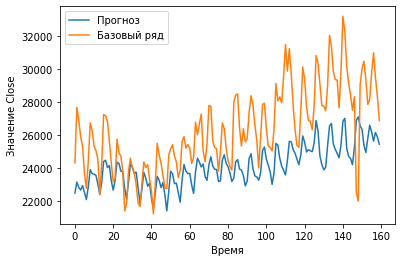

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

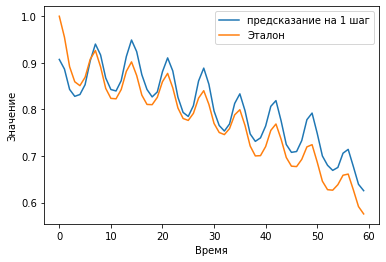

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)